# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

[Te proporcionamos algunos comentarios para orientarte mientras completas este proyecto. Pero debes asegurarte de eliminar todos los comentarios entre corchetes antes de entregar tu proyecto.]

[Antes de sumergirte en el análisis de datos, explica por tu propia cuenta el propósito del proyecto y las acciones que planeas realizar.]

[Ten en cuenta que estudiar, modificar y analizar datos es un proceso iterativo. Es normal volver a los pasos anteriores y corregirlos/ampliarlos para permitir nuevos pasos.]

## Inicialización

In [1]:
# Cargar todas las librerías
from scipy import stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
df_users = pd.read_csv('datasets/megaline_users.csv')
df_plans = pd.read_csv('datasets/megaline_plans.csv')
df_calls = pd.read_csv('datasets/megaline_calls.csv')
df_messages = pd.read_csv('datasets/megaline_messages.csv')
df_internet = pd.read_csv('datasets/megaline_internet.csv')

## Preparar los datos

[Los datos para este proyecto se dividen en varias tablas. Explora cada una para tener una comprensión inicial de los datos. Si es necesario, haz las correcciones requeridas en cada tabla.]

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

El `df_plans` se puede ver a primera vista que no tiene ningún *valor nulo*, en caso de que podamos tener algún plan adicional sería cuestión de también asegurarnos de que no tuviera ningun valor nulo ya que siendo que esta información es fundamental no podríamos trabajar con valores nulos y sería algo que tendríamos que consultar con la fuente de la información.

Como tal no hay un problema con la exportación de los datos, números son números y texto es object, aunque lo mejor para poder trabajar más a gusto con la información es convertir las columnas de moneda, que son enteros, a flotantes siendo que como vamos a manejar estas columnas en los mismos cálculos, va a ser más cómodo trabajar con el mismo tipo de dato común para evitar tener que estar convirtiendo de entero a flotante constantemente; con respecto a los otros campos numéricos, no es necesario cambiar las columnas de MB y de minutos ya que no nos interesa los decimales que pudieran tener.

Y con respecto al orden de las columnas, están bien todas menos la *última*, el nombre del plan debería estar al inicio del orden para mejor comprensión de los datos.

## Corregir datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [5]:
# Reordenar columnas
cols = ['plan_name'] + [col for col in df_plans.columns if col != 'plan_name']
df_plans = df_plans[cols]

# Convertir las columnas de moneda que son enteros a flotantes
df_plans['usd_monthly_pay'] = df_plans['usd_monthly_pay'].astype(float)
df_plans['usd_per_gb'] = df_plans['usd_per_gb'].astype(float)

## Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

Meramente como un dato representativo se puede agregar una columna junto a los MB del plan, se puede agregar una columna con los GB para tener una mejor idea rápida al momento de analizar los datos.

Tal vez como otro dato representativo podría ser una columna con la rentabilidad de cada plan, es decir que cuanto dinero cuesta cada mensaje de texto, minuto por llamada y MB consumido acorde a lo que se paga por plan. Pero no quiero hacer mucho bulto en el df, así que lo dejaré pero comentado, por si se llega a necesitar.

In [6]:
# Datos incluidos pero en GB
df_plans['gb_per_month_included'] = df_plans['mb_per_month_included'] / 1024

# Costo efectivo por unidad incluida
#df_plans['usd_per_included_minute'] = df_plans['usd_monthly_pay'] / df_plans['minutes_included']
#df_plans['usd_per_included_message'] = df_plans['usd_monthly_pay'] / df_plans['messages_included']
#df_plans['usd_per_included_gb'] = df_plans['usd_monthly_pay'] / df_plans['gb_per_month_included']

### Comprobar cambios

In [7]:
df_plans.info()

df_plans.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   plan_name              2 non-null      object 
 1   messages_included      2 non-null      int64  
 2   mb_per_month_included  2 non-null      int64  
 3   minutes_included       2 non-null      int64  
 4   usd_monthly_pay        2 non-null      float64
 5   usd_per_gb             2 non-null      float64
 6   usd_per_message        2 non-null      float64
 7   usd_per_minute         2 non-null      float64
 8   gb_per_month_included  2 non-null      float64
dtypes: float64(5), int64(3), object(1)
memory usage: 276.0+ bytes


,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
0,surf,50,15360,500,20.0,10.0,0.03,0.03,15.0
1,ultimate,1000,30720,3000,70.0,7.0,0.01,0.01,30.0


## Usuarios/as

In [8]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [9]:
# Imprime una muestra de datos para usuarios
df_users.head(20)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

Puedo ver un DataFrame en el que la mayoría de los datos son *object*, voy a cambiar los tipos de dato de las fechas a su tipo correspondiente para poder trabajarlos mejos en los análisis; la columna `plan` es muy relevante y está muy al final, así que lo voy a mover para después de los datos fundamentales del usuario, justo después de `age`, así queda más al alcance esa información, y los datos de fecha quedan un lado al otro.

Con respecto a la información, todo parece estar bien, excepto que en la columna `churn_date` hay muchos valores ausentes, siendo que esta columna representa la fecha en la que los usuarios dejaron de usar o cancelaron su servicio, el hecho de que haya una cantida significativa de valores nulos en esta columna son buenas noticias para el cliente. Que sean valores nulos no nos afecta, aunque como información adicional para nosotros los analistas, una columna extra nos podríá agilizar algunas preguntas, así que en base a esta columna puedo crear una columna tipo booleano llamado `is_churn` que servirá para identificar rápido los usuarios con plan activo.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [10]:
# Reordenar `plan` después de `age`
cols = df_users.columns.tolist()
cols.insert(4, cols.pop(cols.index('plan')))
df_users = df_users[cols]

# Cambiar las columnas de fecha al tipo correspondiente
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [11]:
# Crear una columna booleana para identificar clientes que cancelaron
df_users['is_churn'] = df_users['churn_date'].notna()

### Comprobar cambios

In [12]:
df_users.info()

df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   plan        500 non-null    object        
 5   city        500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   churn_date  34 non-null     datetime64[ns]
 8   is_churn    500 non-null    bool          
dtypes: bool(1), datetime64[ns](2), int64(2), object(4)
memory usage: 31.9+ KB


,user_id,first_name,last_name,age,plan,city,reg_date,churn_date,is_churn
0,1000,Anamaria,Bauer,45,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,NaT,False
1,1001,Mickey,Wilkerson,28,surf,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,NaT,False
2,1002,Carlee,Hoffman,36,surf,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,NaT,False
3,1003,Reynaldo,Jenkins,52,surf,"Tulsa, OK MSA",2018-01-28,NaT,False
4,1004,Leonila,Thompson,40,surf,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,NaT,False


## Llamadas

In [13]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [14]:
# Imprime una muestra de datos para las llamadas
df_calls.head(20)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

Este DataFrame no tiene ninguna columna con datos ausentes, así que podemos quitarnos una preocupación de encima.

Identifico que hay columna tanto para el `id` de cada llamada individual como columna `user_id` para vincular la llamada con el usuario que hizo esa llamada; en esta columna se puede apreciar que los id de los usuarios se repiten, indicanto que los usuarios de muestra han hecho múltiples llamadas a lo largo de su plan.

Nuevamente en este DataFrame, la columna con fecha lo voy a cambiar a su tipo de dato correspondiente, en este caso `call_date` que corresponde a la fecha de cada llamada realizada.

Y está la columna `duration`, la duración de las llamadas en minutos, tiene decimales, pero a petición del cliente vamos a redondear los números al límite superior, no importa si el decimal es 0.1, se va a redondear a 1. Y por consistencia, el tipo de dato se va a cambiar a entero. Ademas puedo observar que hay **duraciones en 0.0 cerrado**, esto podría significar que hay 'llamadas fallidas o no contestadas' o que hay errores en el registro de duración, como sea voy a asumir el primer caso; este último dato lo voy a tener en cuenta en caso de que estas llamadas de duración 0 puedan causar problemas en los cálculos.

Creo que agregar una columna para saber el día de la semana en la que se realizó la llamada podría ser bastante útil para algunas preguntas que nos podríamos hacer.

Como un dato adicional que podríamos solicitar es la hora en la que se hace cada llamada incluido en la fecha de las mismas, nos podría dar más información sobre el comportamiento de los usuarios en caso de que se quisiera hacer estudios al respecto.

Vamos a agregar la columna de `month` ya que este nos va a ayudar con un cálculo específico más adelante.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [15]:
# Cambiar el tipo de dato de la columna de fecha a su tipo correspondiente
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])

# Más que corrección, es un ajuste; redondear las llamadas hacia arriba
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [16]:
# Agregar la columna para saber en qué día de la semana se realizó la llamada
df_calls['weekday'] = df_calls['call_date'].dt.day_name()

# Agrega columna de mes para permitir agrupar por mes
df_calls['month'] = df_calls['call_date'].dt.month

### Comprobar cambios

In [17]:
df_calls.info()

df_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
 4   weekday    137735 non-null  object        
 5   month      137735 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(2), object(2)
memory usage: 5.8+ MB


,id,user_id,call_date,duration,weekday,month
0,1000_93,1000,2018-12-27,9,Thursday,12
1,1000_145,1000,2018-12-27,14,Thursday,12
2,1000_247,1000,2018-12-27,15,Thursday,12
3,1000_309,1000,2018-12-28,6,Friday,12
4,1000_380,1000,2018-12-30,5,Sunday,12


## Mensajes

In [18]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [19]:
# Imprime una muestra de datos para los mensajes
df_messages.head(20)

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
5,1000_346,1000,2018-12-29
6,1000_386,1000,2018-12-30
7,1000_413,1000,2018-12-31
8,1000_502,1000,2018-12-27
9,1000_525,1000,2018-12-28


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

Nuevamente se puede apreciar un DataFrame en el que tiene `id` para cada mensaje individual, `user_id` para vincular cada mensaje con un usuario que envió mensaje, y una columna de fecha `message_date` para identificar la fecha de cada mensaje.

Igual, columna de fecha se modificará a su tipo de dato correspondiente.

Aquí también podría ayudar agregar la columna del día de la semana con fines de análisis.

Como un dato adicional que podríamos solicitar es la hora en la que se envía cada mensaje, incluido en la columna `message_date`, nos podría dar más información sobre el comportamiento de los usuarios en caso de que se quisiera hacer estudios al respecto.

Vamos a agregar la columna de `month` ya que este nos va a ayudar con un cálculo específico más adelante.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [20]:
# Cambiar el tipo de dato en la columna de fecha a su tipo de dato correspondiente.
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [21]:
# Agregar la columna para saber en qué día de la semana se envió el mensaje
df_messages['weekday'] = df_messages['message_date'].dt.day_name()

# Agrega columna de mes para permitir agrupar por mes
df_messages['month'] = df_messages['message_date'].dt.month

### Comprobar cambios

In [22]:
df_messages.info()

df_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   weekday       76051 non-null  object        
 4   month         76051 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(2)
memory usage: 2.6+ MB


,id,user_id,message_date,weekday,month
0,1000_125,1000,2018-12-27,Thursday,12
1,1000_160,1000,2018-12-31,Monday,12
2,1000_223,1000,2018-12-31,Monday,12
3,1000_251,1000,2018-12-27,Thursday,12
4,1000_255,1000,2018-12-26,Wednesday,12


## Internet

In [23]:
# Imprime la información general/resumida sobre el DataFrame de internet
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [24]:
# Imprime una muestra de datos para el tráfico de internet
df_internet.head(20)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

En este DataFrame podemos ver que tampoco hay datos ausentes.

Tiene `id` para identificar una sesión de internet individual, `user_id` para identificar el usuario que hace esa sesión, fecha de la sesión `session_date` y los MB usados en dicha sesión `mb_used`.

El tipo de dato de la columna de fecha será cambiado a su tipo correspondiente.

Por orden del cliente, los MB de las sesiones **no** se redondean individualmente, pero sí se redondea por mes, así que eso corresponderá a calcular más adelante. Lo dejamos con las decimales.

Y una columna para ver el día de la semana en cada sesión también podría ser útil.

Vamos a agregar la columna de `month` ya que este nos va a ayudar con un cálculo específico más adelante.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [25]:
# Cambiar la columna de fecha a su tipo de dato correspondiente
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [26]:
# Columna para identificar el día de la semana de la sesión
df_internet['weekday'] = df_internet['session_date'].dt.day_name()

# Agrega columna de mes para permitir agrupar por mes
df_internet['month'] = df_internet['session_date'].dt.month

### Comprobar cambios

In [27]:
df_internet.info()

df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   weekday       104825 non-null  object        
 5   month         104825 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(2)
memory usage: 4.4+ MB


,id,user_id,session_date,mb_used,weekday,month
0,1000_13,1000,2018-12-29,89.86,Saturday,12
1,1000_204,1000,2018-12-31,0.00,Monday,12
2,1000_379,1000,2018-12-28,660.40,Friday,12
3,1000_413,1000,2018-12-26,270.99,Wednesday,12
4,1000_442,1000,2018-12-27,880.22,Thursday,12


## Estudiar las condiciones de las tarifas

[Es sumamente importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción. Así que te sugerimos imprimir la información de la tarifa para ver una vez más sus condiciones.]

In [28]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
df_plans.head()

,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
0,surf,50,15360,500,20.0,10.0,0.03,0.03,15.0
1,ultimate,1000,30720,3000,70.0,7.0,0.01,0.01,30.0


## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

In [29]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
calls_per_user_month = df_calls.groupby(['user_id', 'month']).size().reset_index(name='call_count')

calls_per_user_month.head()

,user_id,month,call_count
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64


In [30]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
minutes_per_user_month = df_calls.groupby(['user_id', 'month'])['duration'].sum().reset_index(name='total_minutes')

minutes_per_user_month.head()

,user_id,month,total_minutes
0,1000,12,124
1,1001,8,182
2,1001,9,315
3,1001,10,393
4,1001,11,426


In [31]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
messages_per_user_month = df_messages.groupby(['user_id', 'month']).size().reset_index(name='messages_count')

messages_per_user_month.head()

,user_id,month,messages_count
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


In [32]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
internet_usage_per_user_month = df_internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()

# Agregamos columna para redondear los MB a GB por mes, redondeando hacia arriba
internet_usage_per_user_month['gb_used'] = np.ceil(internet_usage_per_user_month['mb_used'] / 1024).astype(int)

internet_usage_per_user_month.head()

,user_id,month,mb_used,gb_used
0,1000,12,1901.47,2
1,1001,8,6919.15,7
2,1001,9,13314.82,14
3,1001,10,22330.49,22
4,1001,11,18504.30,19


[Junta los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.]

In [33]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
# Fusionar llamadas con minutos
monthly_usage = pd.merge(
    calls_per_user_month,
    minutes_per_user_month,
    on=['user_id', 'month'],
    how='outer'
)

# Fusionar mensajes
monthly_usage = pd.merge(
    monthly_usage,
    messages_per_user_month,
    on=['user_id', 'month'],
    how='outer'
)

# Fusionar internet
monthly_usage = pd.merge(
    monthly_usage,
    internet_usage_per_user_month,
    on=['user_id', 'month'],
    how='outer'
)

# Van a haber datos nulos, así que los rellenamos con 0.
monthly_usage = monthly_usage.fillna(0)

In [34]:
# Añade la información de la tarifa
monthly_usage = pd.merge(
    monthly_usage,
    df_users[['user_id', 'plan']],
    on='user_id',
    how='left'
)

[Calcula los ingresos mensuales por usuario:

- Resta el límite del paquete gratuito del número total de llamadas, mensajes de texto y datos
- Multiplica el resultado por el valor del plan de llamadas
- Aañade la tarifa mensual en función del plan de llamadas.

Nota: Dadas las condiciones del plan, ¡esto podría no ser tan trivial como un par de líneas! Así que no pasa nada si dedicas algo de tiempo a ello.]

In [35]:
# Calcula el ingreso mensual para cada usuario
# Unimos los datos del plan con meros fines de cálculos
monthly_usage = pd.merge(
    monthly_usage,
    df_plans,
    left_on='plan',
    right_on='plan_name',
    how='left'
).drop(columns='plan_name')

# Calculamos el excedente por usuario
monthly_usage['minutes_over'] = (monthly_usage['total_minutes'] - monthly_usage['minutes_included']).clip(lower=0)
monthly_usage['messages_over'] = (monthly_usage['messages_count'] - monthly_usage['messages_included']).clip(lower=0)
monthly_usage['gb_over'] = (monthly_usage['gb_used'] - (monthly_usage['mb_per_month_included'] / 1024)).clip(lower=0)

# Calcular el costo por excedentes
monthly_usage['extra_charges'] = (
    monthly_usage['minutes_over'] * monthly_usage['usd_per_minute'] +
    monthly_usage['messages_over'] * monthly_usage['usd_per_message'] +
    monthly_usage['gb_over'] * monthly_usage['usd_per_gb']
)

# Suma los costos fijos con los cargos extras, y redondea a 2 decimales
monthly_usage['total_revenue'] = (monthly_usage['usd_monthly_pay'] + monthly_usage['extra_charges']).round(2)

# Eliminamos las columnas de los cálculos, ya no nos sirven
columns_to_drop = [
    'messages_included',
    'mb_per_month_included',
    'minutes_included',
    'usd_monthly_pay',
    'usd_per_gb',
    'usd_per_message',
    'usd_per_minute',
    'mb_per_month_included',
    'minutes_over',
    'messages_over',
    'gb_over'
]

monthly_usage = monthly_usage.drop(columns=columns_to_drop)

monthly_usage.head()

,user_id,month,call_count,total_minutes,messages_count,mb_used,gb_used,plan,gb_per_month_included,extra_charges,total_revenue
0,1000,12,16.0,124.0,11.0,1901.47,2.0,ultimate,30.0,0.00,70.00
1,1001,8,27.0,182.0,30.0,6919.15,7.0,surf,15.0,0.00,20.00
2,1001,9,49.0,315.0,44.0,13314.82,14.0,surf,15.0,0.00,20.00
3,1001,10,65.0,393.0,53.0,22330.49,22.0,surf,15.0,70.09,90.09
4,1001,11,64.0,426.0,36.0,18504.30,19.0,surf,15.0,40.00,60.00


## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]

[En los comentarios hallarás pistas relevantes para las llamadas, pero no las hay para los mensajes e Internet. Sin embargo, el principio del estudio estadístico que se aplica para ellos es el mismo que para las llamadas.]

**Nota adicional**: Durante mi investigación encontré una librería llamada `seaborn` que agiliza mucho la gráficación

### Llamadas

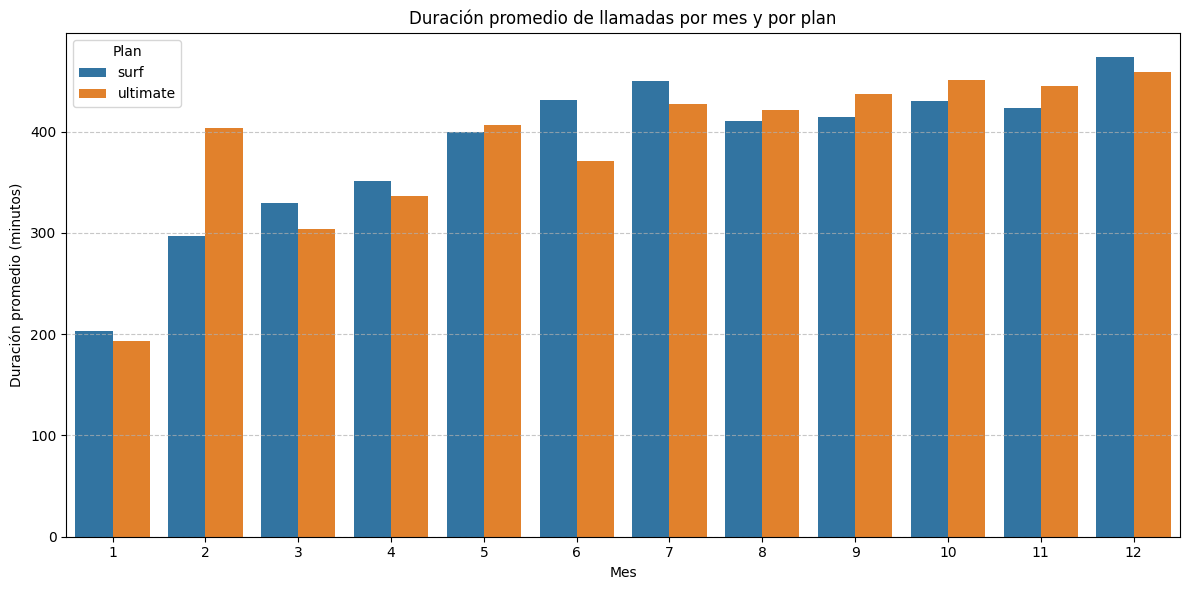

In [36]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
avg_call_duration = monthly_usage.groupby(['plan', 'month'])['total_minutes'].mean().reset_index()

# Graficar
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_call_duration, x='month', y='total_minutes', hue='plan')
plt.title('Duración promedio de llamadas por mes y por plan')
plt.xlabel('Mes')
plt.ylabel('Duración promedio (minutos)')
plt.legend(title='Plan')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

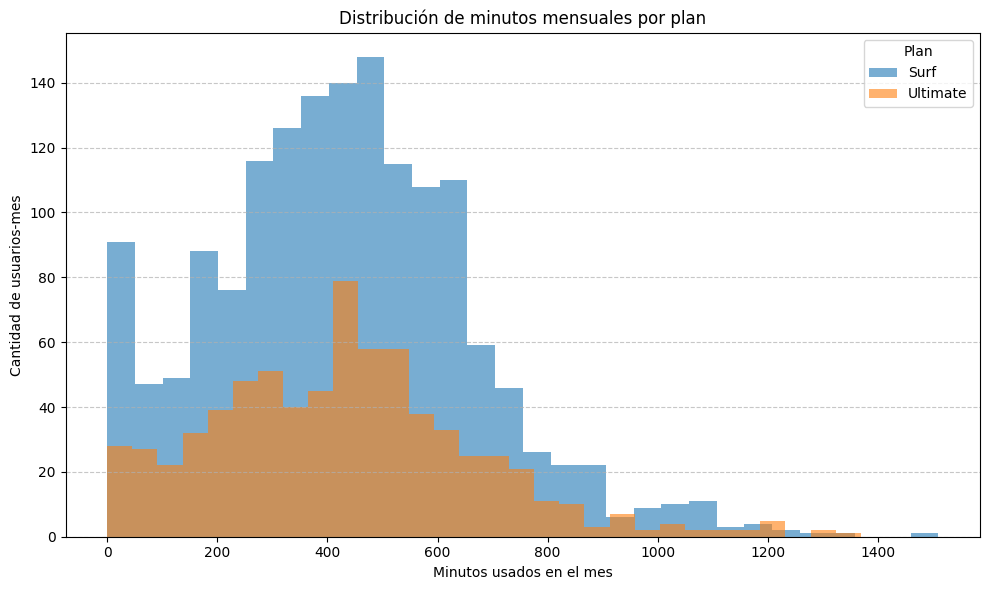

In [37]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
plt.figure(figsize=(10, 6))

for plan in ['surf', 'ultimate']:
    data = monthly_usage[monthly_usage['plan'] == plan]['total_minutes']
    plt.hist(data, bins=30, alpha=0.6, label=plan.capitalize())

plt.title('Distribución de minutos mensuales por plan')
plt.xlabel('Minutos usados en el mes')
plt.ylabel('Cantidad de usuarios-mes')
plt.legend(title='Plan')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [50]:
# Calcula la media y la varianza de la duración mensual de llamadas.
call_stats = monthly_usage.groupby('plan')['total_minutes'].agg(['mean', 'var']).reset_index()
print(call_stats)

       plan        mean           var
0      surf  428.749523  54968.279461
1  ultimate  430.450000  57844.464812


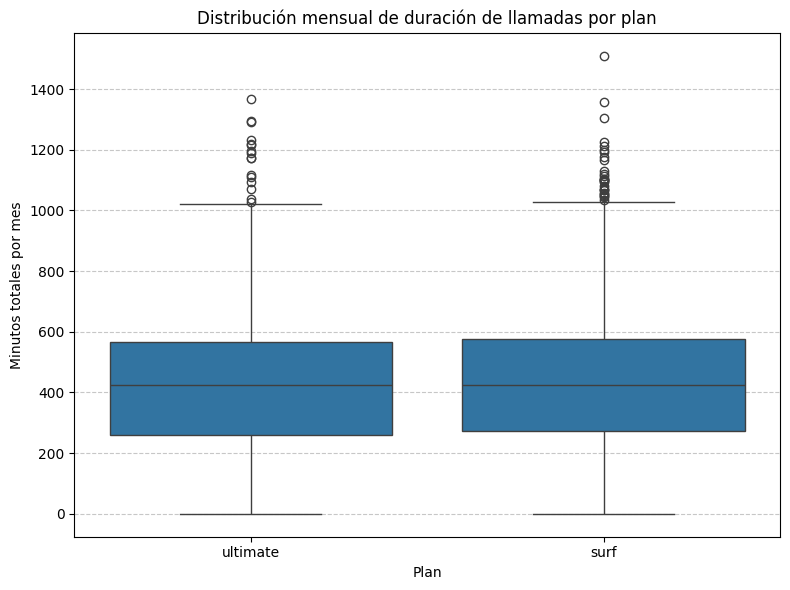

In [51]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
plt.figure(figsize=(8, 6))
sns.boxplot(data=monthly_usage, x='plan', y='total_minutes')
plt.title('Distribución mensual de duración de llamadas por plan')
plt.xlabel('Plan')
plt.ylabel('Minutos totales por mes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a las llamadas. ¿Su comportamiento varía en función del plan?]

De los resultados podemos destacar que:

- **La media** de minutos usados por mes son similares en ambos planes; lo que nos indica un comportamiento ***bastante parejo***.
- **La varianza** entre ambos planes también es parecida y son moderadamente altos, por encima de los 50,000, y no son muy diferentes dado el número alto; lo que sugiere que **hay bastante dispersión** en el uso entre los usuarios, es decir que hay usuarios que usan pocos minutos y otros muchos minutos, y de igual forma tienen un comportamiento **bastante parejo**, no varía dependiendo del plan.

### Mensajes

In [ ]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan



In [ ]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan



[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a los mensajes. ¿Su comportamiento varía en función del plan?]

### Internet

[Elabora las conclusiones sobre cómo los usuarios tienden a consumir el tráfico de Internet. ¿Su comportamiento varía en función del plan?]

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

[Elabora las conclusiones sobre cómo difiere el ingreso entre los planes.]

## Prueba las hipótesis estadísticas

[Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [ ]:
# Prueba las hipótesis



[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [ ]:
# Prueba las hipótesis



## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]